## Assingment 1
*by Ebba Bergman*

Let's do something very similar to the lab

**Hand in:**This notebook, and a pdf of this notebook. No written answers to the questions are required, they are only here to help you learn

**You are free to discuss the general concepts with other groups, but we encourage you not to exchange code for your own learning**

A lot of the code below is inspired labs developed by Christophe Avenel at NBIS , labs and assignments made by Phil Harrison as well as  by https://www.tensorflow.org/guide/keras/functional/,


In [6]:
## First we need to import all of the packages we need

import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cnn_helper

Note: the cnn_helper was written by Christophe Avenel, and his code (including his lab which this one is based on), is available here: https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/tree/master/session_convolutionalNeuralNetworks/Labs

In [7]:
    
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(131)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')    

    ax = fig.add_subplot(133)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    plt.show()
    plt.close()
    
    plt.savefig("History Plot.png")


## Set up the data, look at it

In [8]:
## Set up where to find our data
data_directory = "./LabData/bloodcells_small/data/"
labels_path =  "./LabData/bloodcells_small/labels.csv"


In [9]:
# This is a dataframe, a way to look at data as tables.
#Google "Python pandas dataframe" to get more information, or to find new commands as you need
# Anything you can do with data frames you could do with loops, but it is sometimes easier to read and write code with dataframes
df_labels = pd.read_csv(labels_path) 

### Q: Look at the labels, what columns do you think contains the true label?

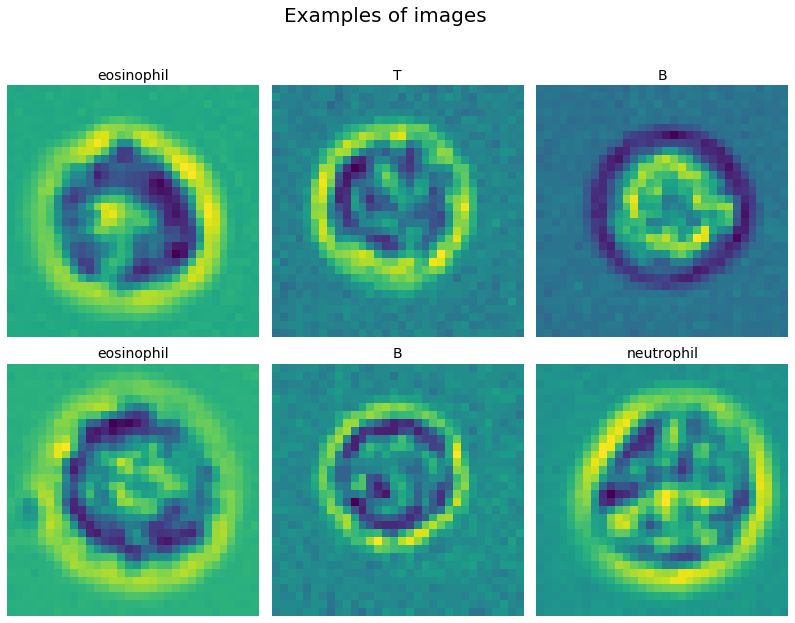

In [10]:
## Let's look at the images - always a good start to the project
# Here random images will be displayed, run this several time to see different images

figure, ax = plt.subplots(2, 3, figsize=(14, 10))
figure.suptitle("Examples of images", fontsize=20)
axes = ax.ravel()

df_images_to_show = df_labels.sample(8)


for i in range(len(axes)):
    row = df_images_to_show.iloc[[i]]
    random_image = Image.open(data_directory + row["Filenames"].values[0])
    axes[i].set_title(row["Class"].values[0], fontsize=14) 
    axes[i].imshow(random_image)
    axes[i].set_axis_off()
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()


### Q: Can you see any difference between the classes? 
### Q: Do you think a human being able to see the difference between classes makes it an easier or more difficult problem for a neural network?

In [11]:
# What's the shape of the image?
image_shape = np.array(random_image).shape
print(image_shape)

(32, 32)


In [12]:
# Let's look a little bit into the labels
set_size = df_labels.size
print(set_size)
print(df_labels.head())

41578
                Filenames Class
0  CRF022_T_1_ch5_106.png     T
1  CRF022_T_1_ch5_119.png     T
2  CRF022_T_1_ch5_123.png     T
3  CRF022_T_1_ch5_128.png     T
4  CRF022_T_1_ch5_134.png     T


In [13]:
df_labels['Class'].value_counts()

neutrophil    4500
monocyte      4303
T             4100
B             4032
eosinophil    3854
Name: Class, dtype: int64

## Divide the data for training, validation and test

In [14]:
## Next, let's divide the filtered rows into a train, validation and a test set. 
class_column_header = "Class"
df_to_use = df_labels.copy() #We're copying the df_labels so that you can look at it again later if you want

test_set_fraction = 0.1
validation_set_fraction = 0.2

df_test = df_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_to_use = pd.concat([df_to_use, df_test, df_test]).drop_duplicates(keep=False) # This line finds the intersection between df_filtered and df_test and df_test and dropps anything that belongs to two of those, so we are left with df_train. Using only df_test once should be fine, but better safe than sorry
df_valid = df_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_train = pd.concat([df_to_use, df_valid, df_valid]).drop_duplicates(keep=False) 

In [15]:
print(df_test.head())

                   Filenames Class
19071  CRF132_B_1_ch5_73.png     B
17414  CRF034_B_2_ch5_55.png     B
19390  CRF132_B_3_ch5_15.png     B
18484  CRF074_B_3_ch5_23.png     B
17214  CRF022_B_3_ch5_30.png     B


In [16]:
## Set up generators that specify how the images are loaded, how many at a time (batch size),
## that the images should be shuffled etc.
batch_size = 8

filename_column = 'Filenames'
true_value = "Class"
# create a data generator

## Note: we tend to get better results if the values of the pixels are between 0 and 1, so we need a rescale of 1/255 since the highest possible pixel value for these images are 255
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_valid, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps=train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps=valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1



Found 14968 validated image filenames belonging to 5 classes.
Found 3743 validated image filenames belonging to 5 classes.
Found 2078 validated image filenames belonging to 5 classes.


# CNN

Convolutional Neural Networks revolutionized the field of deep learning. You have seen how convolutions work in the lectures. One of the huge benefits of convolutions is that as the filters (sometimes called kernels in codes) move across the image the position of an object in an image becomes much less important than when we flattened images to use in traditional Artificial Neural Networks. 
  
For this part of the lab you will try a couple of different architectures and hyperparameters. The **architecture** is basically the structure of the network: how many nodes, how many layers, and overall shape of these. The **hyperparamters** are most easily defined as all of the parameters changed *before* the training of the network begin, such as the number of epochs, what activation function to use in each layer, and which optimization method we use for backpropagation.  

In [13]:
## Set up the model architecture
# See https://www.tensorflow.org/guide/keras/functional/ if you want to see the documentation

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(1, kernel_size=(3, 3), strides=1,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

In [21]:
## Define the model as a keras model
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_1")

In [22]:
## We'll use the same generators as above here, so no need to redefine them
## compile model

cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 1)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
_________________________________________________________________


In [26]:
## Actually train model
epochs = 8
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/8
1871/1871 [==============================] - 20s 11ms/step - loss: 0.5173 - accuracy: 0.8115 - val_loss: 0.5448 - val_accuracy: 0.7875
Epoch 2/8
1871/1871 [==============================] - 14s 8ms/step - loss: 0.5062 - accuracy: 0.8140 - val_loss: 0.5234 - val_accuracy: 0.8116
Epoch 3/8
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4984 - accuracy: 0.8167 - val_loss: 0.5334 - val_accuracy: 0.8001
Epoch 4/8
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4922 - accuracy: 0.8183 - val_loss: 0.5192 - val_accuracy: 0.8086
Epoch 5/8
1871/1871 [==============================] - 32s 17ms/step - loss: 0.4860 - accuracy: 0.8226 - val_loss: 0.5196 - val_accuracy: 0.8065
Epoch 6/8
1871/1871 [==============================] - 14s 7ms/step - loss: 0.4832 - accuracy: 0.8265 - val_loss: 0.5107 - val_accuracy: 0.8065
Epoch 7/8
1871/1871 [==================

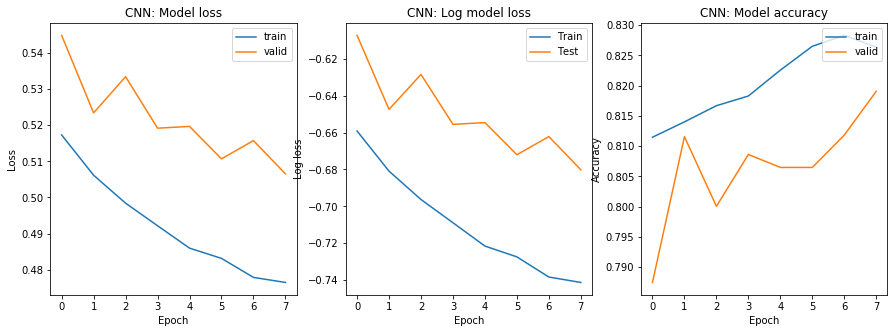

<Figure size 432x288 with 0 Axes>

In [27]:
## Plot results
plot_history(history, "CNN")

Accuracy: 0.8185947101255677


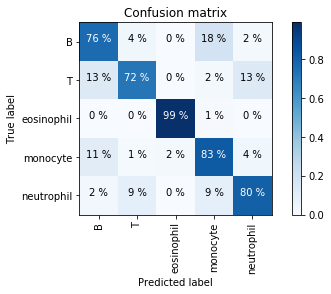

In [28]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### Q: What do the curves tell you about the models?

You can see some examples of how curves can look at : https://uppsala.instructure.com/courses/23804/pages/deep-learning-plots/edit

# Expanding the models

## Deeper models


Sometimes a deeper model and/or a more complex model, can be helpful. Try adding some more convolution layers and pooling layers to the model. Try changing the filter sizes, and the number of filters as well.
More information about the convolutional layer can be found here: https://keras.io/api/layers/convolution_layers/convolution2d/, maxpooling here: https://keras.io/api/layers/pooling_layers/max_pooling2d/, and a different kind of way of making models can be found here: https://www.tensorflow.org/tutorials/images/cnn  and here https://www.tensorflow.org/tutorials/quickstart/advanced

In [184]:
## Set up the model architecture
## v.1.1
# Accuracy validation: 0.9419
# Comment: Could run more than 10 epochs.
##

#Change the code below so that the new model has roughly the same number of parameters as your best ANN
# Hint: you can add both more Conc2D layers, and increase the kernel (filter) size

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_2")

## Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 

In [183]:
## Set up the model architecture
# Larger kernel from 3 to 5
##
# Accuracy validation: 0.9430 
# Comment: Hard to train for validationi the accuracy goes up and down between 0.93 and 0.94, seems to be over fitted
##


#Change the code below so that the new model has roughly the same number of parameters as your best ANN
# Hint: you can add both more Conc2D layers, and increase the kernel (filter) size

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(5, 5), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(5, kernel_size=(5, 5), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_2")

## Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 32, 32, 5)         130       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 16, 16, 5)         630       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 

In [152]:
## Set up the model architecture
# Small kernel from 3 to 1
##
# Accuracy validation: 0.9349
# Comment: Nice
##


#Change the code below so that the new model has roughly the same number of parameters as your best ANN
# Hint: you can add both more Conc2D layers, and increase the kernel (filter) size

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(1, 1), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(5, kernel_size=(1, 1), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_2")

## Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 5)         10        
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 5)         30        
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 

In [142]:
## Set up the model architecture
# Big pool size from 2 and 2 to 8 and 4. Results in a feature maps of size 1.
##
# Accuracy validation: 0.8454
# Increased epoch to 20, still got questionable results :/
##


#Change the code below so that the new model has roughly the same number of parameters as your best ANN
# Hint: you can add both more Conc2D layers, and increase the kernel (filter) size

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(8, 8))(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_2")

## Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 4, 4, 5)           0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 4, 4, 5)           230       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 1, 1, 5)           0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 5)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 

In [153]:
## Actually train model
epochs = 10
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
                                 )         

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 20s 11ms/step - loss: 0.5338 - accuracy: 0.8208 - val_loss: 0.3285 - val_accuracy: 0.8908
Epoch 2/10
1871/1871 [==============================] - 14s 7ms/step - loss: 0.3059 - accuracy: 0.9020 - val_loss: 0.2735 - val_accuracy: 0.9111
Epoch 3/10
1871/1871 [==============================] - 14s 8ms/step - loss: 0.2669 - accuracy: 0.9174 - val_loss: 0.2565 - val_accuracy: 0.9157
Epoch 4/10
1871/1871 [==============================] - 14s 8ms/step - loss: 0.2486 - accuracy: 0.9224 - val_loss: 0.2503 - val_accuracy: 0.9208
Epoch 5/10
1871/1871 [==============================] - 16s 8ms/step - loss: 0.2375 - accuracy: 0.9276 - val_loss: 0.2319 - val_accuracy: 0.9264
Epoch 6/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.2288 - accuracy: 0.9290 - val_loss: 0.2299 - val_accuracy: 0.9272
Epoch 7/10
1871/1871 [============

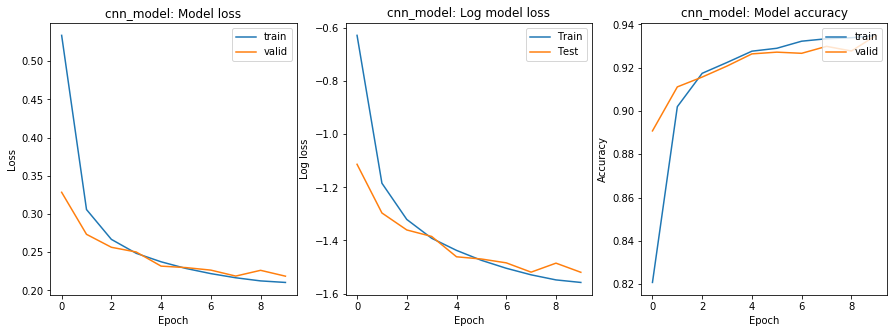

Accuracy: 0.9345444830349987


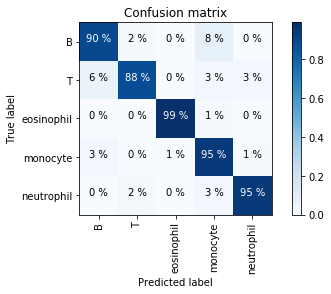

In [154]:
## Plot results
plot_history(history, "cnn_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

## Try a couple of deeper models and save your best one for further study


### Add all these models beneath this heading

## Data Augmentation


Let's try something else, maybe you would like to add some data augmentation? 
Data augmentation basically means that we randomly alter the incoming images in different ways to make sure that the network can handle those types of variations.

If you want to read more you can look at this article, especially the "Data Augmentations based on basic image manipulations Geometric transformations" is of interest here: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for things you can try by adding input paramters to the ImageDataGenerator().


Update the cell below to  **include data augmentations, only in the training data generator then run your CNN again**

In [155]:
## Set up generators 
batch_size = 8

filename_column = 'Filenames'
true_value = "Class"
# create a data generator

## Note: we tend to get better results if the values of the pixels are between 0 and 1, so we need a rescale of 1/255 since the highest possible pixel value for these images are 255
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True, horizontal_flip=True, vertical_flip=True)## ADD CODE HERE)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_valid, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps=train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps=valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1


Found 14968 validated image filenames belonging to 5 classes.
Found 3743 validated image filenames belonging to 5 classes.
Found 2078 validated image filenames belonging to 5 classes.


In [156]:
## Set up the model architecture
### use your best model from above, and rename it here to cnn_model_augmented
cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

In [157]:
## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_augmented")

In [158]:
## Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)         

In [159]:
## Actually train model
epochs = 10
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 21s 11ms/step - loss: 0.5312 - accuracy: 0.8088 - val_loss: 0.3096 - val_accuracy: 0.8967
Epoch 2/10
1871/1871 [==============================] - 21s 11ms/step - loss: 0.2787 - accuracy: 0.9088 - val_loss: 0.2385 - val_accuracy: 0.9237
Epoch 3/10
1871/1871 [==============================] - 14s 7ms/step - loss: 0.2360 - accuracy: 0.9244 - val_loss: 0.2273 - val_accuracy: 0.9275
Epoch 4/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.2204 - accuracy: 0.9315 - val_loss: 0.2362 - val_accuracy: 0.9267
Epoch 5/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.2113 - accuracy: 0.9317 - val_loss: 0.1950 - val_accuracy: 0.9403
Epoch 6/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.2015 - accuracy: 0.9363 - val_loss: 0.2018 - val_accuracy: 0.9320
Epoch 7/10
1871/1871 [===========

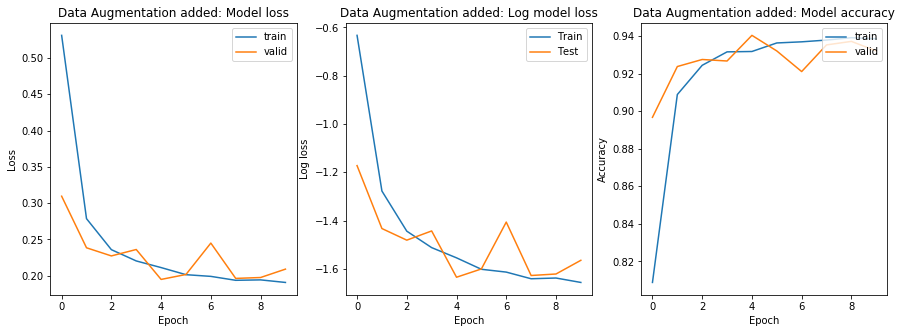

<Figure size 432x288 with 0 Axes>

In [160]:
## Plot results
plot_history(history, "Data Augmentation added")

Accuracy: 0.9318728292813251


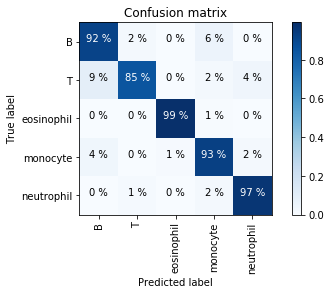

In [161]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### Q: Did the data augmentation help? Why or why not? What makes this dataset more or less likely to be helped by data augmentation?


<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">question above</font></code></b>
</font>
</summary>
    1. Are the blood cells at random places in the image? No
    
2. Look at some of the images. Are the bloodcells centered? What could rotations or zooms change about this? It would change nothing
    
3. Are there color changes you could compensate for? 
</details>

## Regularisation methods


Both BatchNormalization and DropOut are two different regularisation methods. Try adding both to the best working CNN model.  
  
Read more about BatchNormalization here: https://keras.io/api/layers/normalization_layers/batch_normalization/
Read more about DropOut here:https://keras.io/api/layers/regularization_layers/dropout/

### Q:  What are the main similarities and differences between these methods?

In [162]:

# Create the model here
## Set up the model architecture
### use your best model from above

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)


In [163]:
cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

In [164]:
## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model")

In [165]:
## Compile the model

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()
print(cnn_model.layers)

Model: "cnn_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 5)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 5)         20        
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 8, 8, 5)           0 

In [166]:
## Actually train model
epochs = 15
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/15
1871/1871 [==============================] - 26s 14ms/step - loss: 1.4251 - accuracy: 0.3952 - val_loss: 1.0239 - val_accuracy: 0.6089
Epoch 2/15
1871/1871 [==============================] - 15s 8ms/step - loss: 0.9046 - accuracy: 0.6472 - val_loss: 0.7296 - val_accuracy: 0.7184
Epoch 3/15
1871/1871 [==============================] - 15s 8ms/step - loss: 0.6930 - accuracy: 0.7455 - val_loss: 0.5983 - val_accuracy: 0.7749
Epoch 4/15
1871/1871 [==============================] - 15s 8ms/step - loss: 0.5814 - accuracy: 0.7925 - val_loss: 0.5229 - val_accuracy: 0.8126
Epoch 5/15
1871/1871 [==============================] - 16s 8ms/step - loss: 0.5226 - accuracy: 0.8210 - val_loss: 0.4852 - val_accuracy: 0.8231
Epoch 6/15
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4790 - accuracy: 0.8383 - val_loss: 0.4559 - val_accuracy: 0.8346
Epoch 7/15
1871/1871 [============

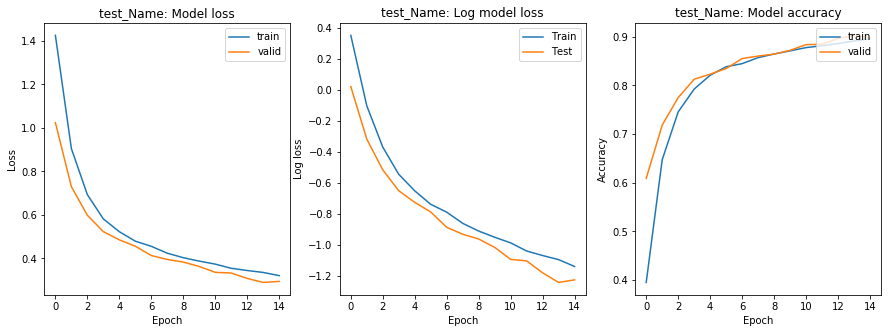

Accuracy: 0.8979428266096714


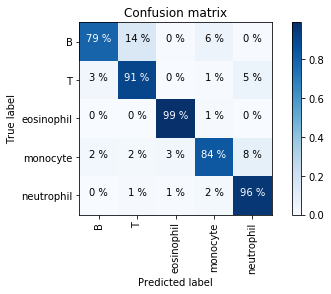

In [167]:
## Plot results
plot_history(history, "test_Name")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### Q: Is there such a thing as too much regularisation?

# Visualise your best CNN

Use the code below to visualise some of the weights you have trained. Hint: Weights are present in convolutional filters and dense layers, nowhere else.
### Visualize both one layer with filters, and the outputlayer

In [168]:
# Pick the layer 
print(cnn_model.layers)
cw1 = np.array(cnn_model.layers[1].get_weights()) ## Pick the layer whose weights you want to visualise
print(cw1.shape) # 2 weight, 1 weight, 1 bias
print(cw1[0].shape) # Weights
print(cw1[1].shape) # Biases
matrix = cw1[0]

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f40a427fb70>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f40a427f3c8>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f40a427fa58>, <tensorflow.python.keras.layers.core.Dropout object at 0x7f40a43983c8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f40a4398828>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f40a4398358>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f40a46f60f0>, <tensorflow.python.keras.layers.core.Flatten object at 0x7f407c793d30>, <tensorflow.python.keras.layers.core.Dense object at 0x7f40540d1240>]
(2,)
(3, 3, 1, 5)
(5,)


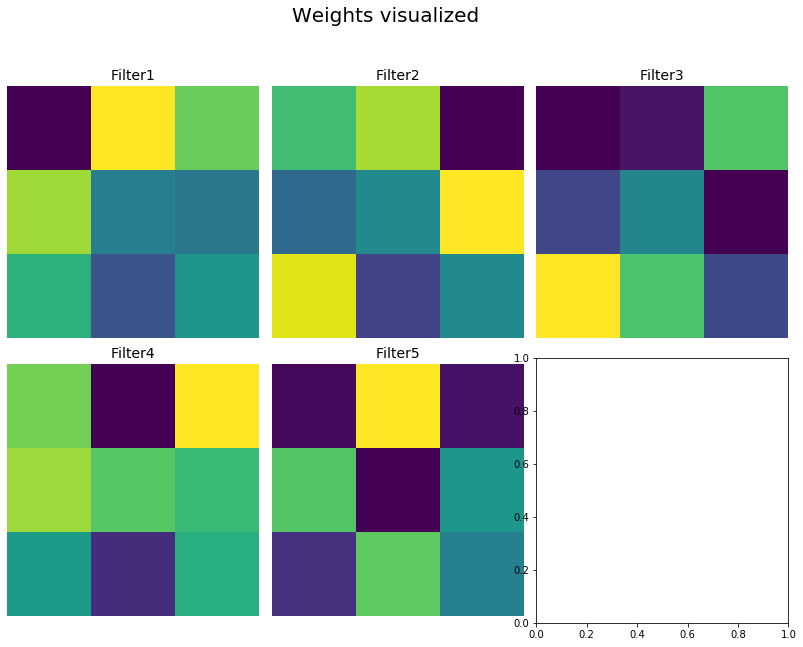

In [169]:
# Plot your filters 
figure, ax = plt.subplots(2, 3, figsize=(14, 10))
figure.suptitle("Weights visualized", fontsize=20)
axes = ax.ravel()

for i in range(0, 5): # Range should be 0 - the number of filters you have
    image = matrix[:,:,:,i:i+1]
    image = np.reshape(image, (3, 3)) ## Reshape to the size of your filters
    axes[i].set_title("Filter" + str(i+1), fontsize=14) 
    axes[i].imshow(image)
    axes[i].set_axis_off()
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

# Using existing models 

One great thing to do when making a CNN model is to use an architecture that has worked for simmilar cases. I happen to know that the existing CNN model VGG16 is a good model for these types of images, try that one next.

There are many way of visualising neural networks, see https://datascience.stackexchange.com/questions/12851/how-do-you-visualize-neural-network-architectures, but here is one made by Christophe Avenel

<img src="Illustrations/vgg16.png" title="VGG16 model"/>

### VGG16

In [101]:
vgg_model = keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=(32, 32, 1),
    pooling=None,
)


In [102]:

# add new classifier layers
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
class1 = layers.Dense(1024, activation='relu')(flat1)
output = layers.Dense(5, activation='softmax')(class1)


In [103]:

vgg_model = keras.Model(inputs=vgg_model.inputs, outputs=output)

print (vgg_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

### Q: How many parameters does this model have?

In [104]:
## Compile the model

vgg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

### Q: Why do we need a new classification layers?

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">question above</font></code></b>
</font>
</summary>
1. What is the original network classifying? 

2. What do we want to classify? 
    
<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">The hint, if you need it</font></code></b>
</font>
</summary>
1. So how do we remove the previous classification and make the new one? Just like the code above naturally! A flattening layer is almost always followed by a dense layer or two to expand the model, and then a final classification layer.
    

</details>
</details>

In [105]:
## Actually train model
epochs = 10
history = vgg_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 34s 18ms/step - loss: 0.7961 - accuracy: 0.6388 - val_loss: 0.3651 - val_accuracy: 0.8959
Epoch 2/10
1871/1871 [==============================] - 32s 17ms/step - loss: 0.2542 - accuracy: 0.9170 - val_loss: 0.2209 - val_accuracy: 0.9221
Epoch 3/10
1871/1871 [==============================] - 32s 17ms/step - loss: 0.2022 - accuracy: 0.9369 - val_loss: 0.1753 - val_accuracy: 0.9425
Epoch 4/10
1871/1871 [==============================] - 32s 17ms/step - loss: 0.1784 - accuracy: 0.9429 - val_loss: 0.1382 - val_accuracy: 0.9553
Epoch 5/10
1871/1871 [==============================] - 33s 18ms/step - loss: 0.1654 - accuracy: 0.9486 - val_loss: 0.1406 - val_accuracy: 0.9569
Epoch 6/10
1871/1871 [==============================] - 31s 17ms/step - loss: 0.1540 - accuracy: 0.9502 - val_loss: 0.1672 - val_accuracy: 0.9499
Epoch 7/10
1871/1871 [=======

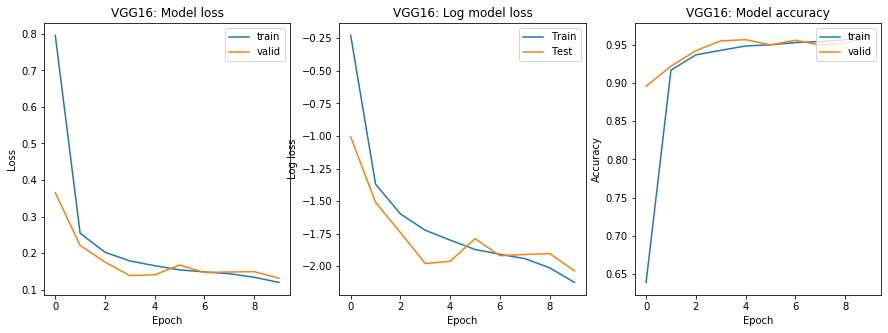

<Figure size 432x288 with 0 Axes>

In [106]:
## Plot results
plot_history(history, "VGG16")

Accuracy: 0.9599251936948971


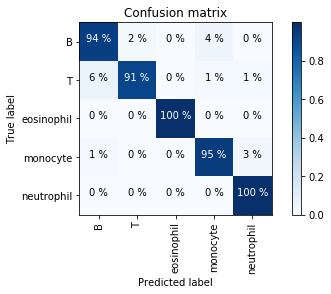

In [107]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(vgg_model, valid_generator)

### Q: What is your worst performing class in this classifier? Is it the same as in the other ones?

### Q: How many layers with 10 filters of size 3*3 would you have to add to the first CNN model we designed to achieve the same number of parameters?  

# Try some more models.

Try other optimizers, learning rates, batch sizes or number of epochs. Which would you like to try first and why? Show atleast 4 models


In [33]:
## Set up the model architecture
## 
# Model try 1
# Accuracy validation: 0.9433
# Comment: Gives good result but the model seems over fitted so for next test a drop out layer is added
##

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model_final = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="final_model")

## Compile the model
cnn_model_final.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model_final.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 

In [34]:
## Actually train model
epochs = 10
history = cnn_model_final.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs,
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 24s 13ms/step - loss: 0.4846 - accuracy: 0.8270 - val_loss: 0.2676 - val_accuracy: 0.9141
Epoch 2/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.2395 - accuracy: 0.9250 - val_loss: 0.2117 - val_accuracy: 0.9301
Epoch 3/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.2047 - accuracy: 0.9357 - val_loss: 0.2145 - val_accuracy: 0.9293
Epoch 4/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.1902 - accuracy: 0.9393 - val_loss: 0.2147 - val_accuracy: 0.9296
Epoch 5/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.1801 - accuracy: 0.9423 - val_loss: 0.2119 - val_accuracy: 0.9293
Epoch 6/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.1743 - accuracy: 0.9430 - val_loss: 0.1740 - val_accuracy: 0.9435
Epoch 7/10
1871/1871 [============

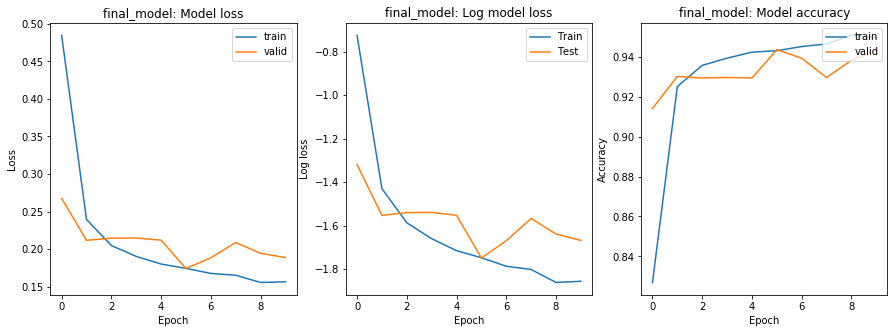

Accuracy: 0.943093775046754


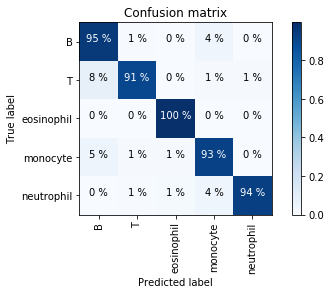

In [35]:
## Plot results
plot_history(history, "final_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model_final, valid_generator)

In [54]:
## Set up the model architecture
## 
# Model try 2
# Added drop out layer of 0.1 rate.
# Accuracy validation: 0.9384
# Comment: A bit worse accuracy, but this model does not over-fit the data.
##

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(.1)(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model_final = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="final_model")

## Compile the model
cnn_model_final.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model_final.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 320)               

In [55]:
## Actually train model
epochs = 10
history = cnn_model_final.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs,
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 19s 10ms/step - loss: 0.5587 - accuracy: 0.7994 - val_loss: 0.3209 - val_accuracy: 0.8953
Epoch 2/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.3008 - accuracy: 0.9033 - val_loss: 0.2277 - val_accuracy: 0.9312
Epoch 3/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.2396 - accuracy: 0.9228 - val_loss: 0.2196 - val_accuracy: 0.9264
Epoch 4/10
1871/1871 [==============================] - 16s 8ms/step - loss: 0.2188 - accuracy: 0.9309 - val_loss: 0.2140 - val_accuracy: 0.9248
Epoch 5/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.2017 - accuracy: 0.9352 - val_loss: 0.1867 - val_accuracy: 0.9374
Epoch 6/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.1984 - accuracy: 0.9382 - val_loss: 0.1766 - val_accuracy: 0.9408
Epoch 7/10
1871/1871 [============

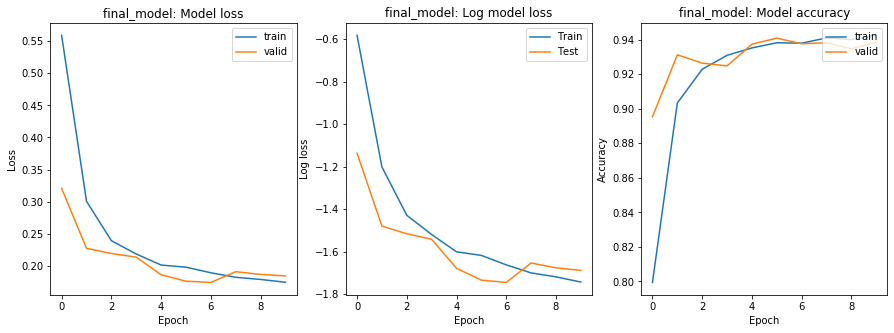

Accuracy: 0.9382847982901416


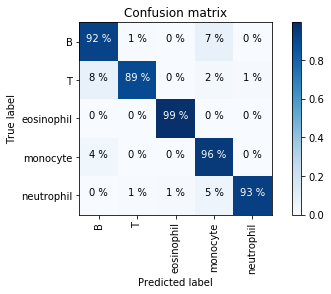

In [56]:
## Plot results
plot_history(history, "final_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model_final, valid_generator)

In [57]:
## Set up the model architecture
## 
# Model try 3
# Changed the Conv2D kernel to see if there is any change in performence, note that stride is also changed
# Accuracy validation: 0.9066
# Comment: Did nit improve the performence, conclude that kernel size of 3x3 is better.
##

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(4, 4), strides=2,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(.1)(x)
x = layers.Conv2D(5, kernel_size=(4, 4), strides=2,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model_final = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="final_model")

## Compile the model
cnn_model_final.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model_final.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 5)         85        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 5)           0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 5)           405       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 2, 2, 5)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 20)                

In [58]:
## Actually train model
epochs = 10
history = cnn_model_final.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs,
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 23s 12ms/step - loss: 0.9322 - accuracy: 0.6289 - val_loss: 0.5939 - val_accuracy: 0.7968
Epoch 2/10
1871/1871 [==============================] - 14s 8ms/step - loss: 0.5645 - accuracy: 0.7974 - val_loss: 0.4470 - val_accuracy: 0.8539
Epoch 3/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4625 - accuracy: 0.8429 - val_loss: 0.4179 - val_accuracy: 0.8643
Epoch 4/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.4213 - accuracy: 0.8582 - val_loss: 0.3683 - val_accuracy: 0.8790
Epoch 5/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.4028 - accuracy: 0.8693 - val_loss: 0.3398 - val_accuracy: 0.8967
Epoch 6/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.3769 - accuracy: 0.8771 - val_loss: 0.3328 - val_accuracy: 0.8969
Epoch 7/10
1871/1871 [============

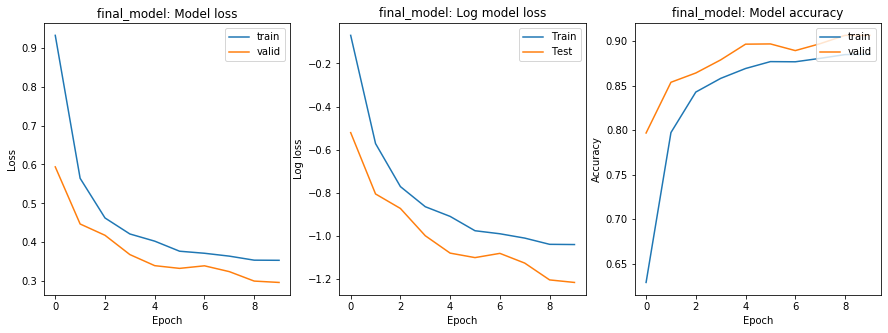

Accuracy: 0.2121293080416778


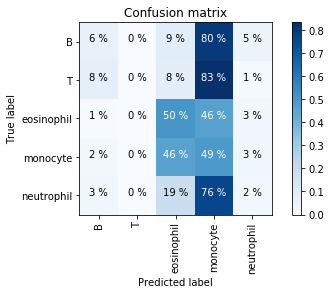

In [61]:
## Plot results
plot_history(history, "final_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model_final, valid_generator)

In [62]:
## Set up the model architecture
## 
# Model try 4
# Try another optimizer instead of Adam try SGD
# Accuracy validation: 0.9344
# Comment: Not a whole lot worse than model 2, but the difference is expected.
##

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(.1)(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model_final = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="final_model")

## Compile the model
cnn_model_final.compile(optimizer=keras.optimizers.SGD(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model_final.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 320)               

In [63]:
## Actually train model
epochs = 10
history = cnn_model_final.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs,
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 23s 12ms/step - loss: 0.7054 - accuracy: 0.7291 - val_loss: 0.4113 - val_accuracy: 0.8627
Epoch 2/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.3928 - accuracy: 0.8626 - val_loss: 0.2909 - val_accuracy: 0.9071
Epoch 3/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.3340 - accuracy: 0.8844 - val_loss: 0.3114 - val_accuracy: 0.8916
Epoch 4/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.2856 - accuracy: 0.9018 - val_loss: 0.2333 - val_accuracy: 0.9240
Epoch 5/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.2620 - accuracy: 0.9122 - val_loss: 0.2339 - val_accuracy: 0.9251
Epoch 6/10
1871/1871 [==============================] - 16s 9ms/step - loss: 0.2484 - accuracy: 0.9171 - val_loss: 0.2100 - val_accuracy: 0.9248
Epoch 7/10
1871/1871 [============

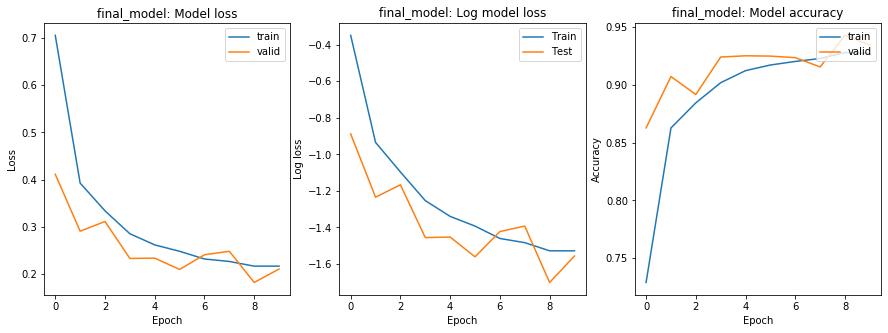

Accuracy: 0.9342773176596313


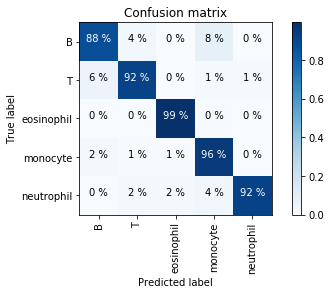

In [64]:
## Plot results
plot_history(history, "final_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model_final, valid_generator)

# Finally test your best model

In [68]:
## Set up the model architecture
##
# Took the best model and increased the number of epochs
# Accuracy validation: 0.9406
##

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same', activation=tf.nn.relu)(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(.2)(x)
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model_final = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="final_model")

## Compile the model
cnn_model_final.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model_final.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 5)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 5)         230       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 320)               

In [69]:
## Actually train model
epochs = 10
history = cnn_model_final.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs,
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.6162 - accuracy: 0.7646 - val_loss: 0.3613 - val_accuracy: 0.8755
Epoch 2/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.3207 - accuracy: 0.8935 - val_loss: 0.2413 - val_accuracy: 0.9200
Epoch 3/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.2597 - accuracy: 0.9133 - val_loss: 0.2039 - val_accuracy: 0.9358
Epoch 4/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.2381 - accuracy: 0.9204 - val_loss: 0.2237 - val_accuracy: 0.9221
Epoch 5/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.2165 - accuracy: 0.9292 - val_loss: 0.1929 - val_accuracy: 0.9363
Epoch 6/10
1871/1871 [==============================] - 18s 10ms/step - loss: 0.2129 - accuracy: 0.9290 - val_loss: 0.2168 - val_accuracy: 0.9205
Epoch 7/10
1871/1871 [============

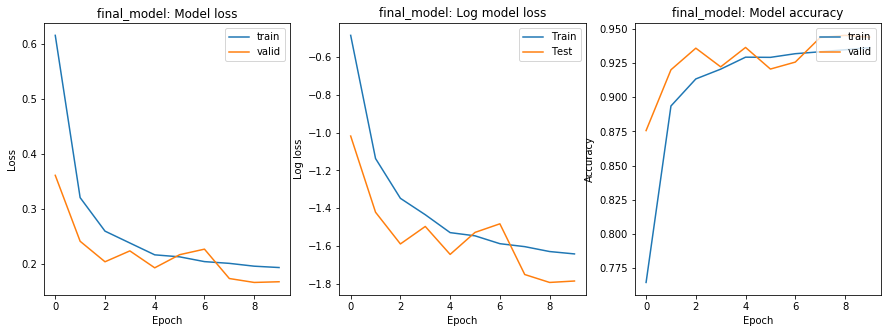

In [ ]:
## Plot results
plot_history(history, "final_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model_final, valid_generator)

In [221]:
test_steps=test_generator.n//test_generator.batch_size if test_generator.n >= test_generator.batch_size else 1

pred=cnn_model_final.predict_generator(test_generator,
steps=test_steps,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
259/259 [==============================] - 2s 8ms/step


Accuracy: 0.9379210779595765


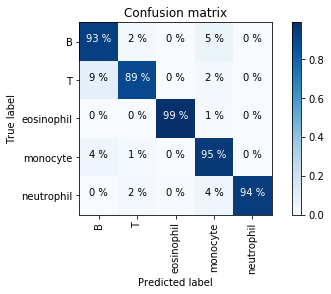

In [223]:
cnn_helper.plot_confusion_matrix_from_generator(cnn_model_final, test_generator) ## replace unknown_model with your best model

# ANN 

Make a neural network without any convolutions that achieves atleast 90% on the validation test. It will be possible with the techniques you have used above.

In [94]:
## Set up the model architecture
inputs = keras.Input(shape= (32,32,1))
#Extend your model here (atleast)
# 32*32=1024
x = layers.Flatten()(inputs)
x = layers.Dense(70, activation=tf.nn.relu)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(20, activation=tf.nn.relu)(x)
#x = layers.Dropout(.2)(x)
outputs = layers.Dense(5, activation="softmax")(x)

In [95]:
## Define the model 
ann_model = keras.Model(inputs=inputs, outputs=outputs, name="ann_Model")

In [96]:
## Compile the model
ann_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
ann_model.summary()

Model: "ann_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 70)                71750     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 20)                1420      
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 105       
Total params: 73,275
Trainable params: 73,275
Non-trainable params: 0
_____________________________________________________

In [97]:
## Actually train model
epochs = 25
history = ann_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/25
1871/1871 [==============================] - 25s 13ms/step - loss: 0.7574 - accuracy: 0.7149 - val_loss: 0.4422 - val_accuracy: 0.8295
Epoch 2/25
1871/1871 [==============================] - 14s 8ms/step - loss: 0.5127 - accuracy: 0.8149 - val_loss: 0.3739 - val_accuracy: 0.8672
Epoch 3/25
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4624 - accuracy: 0.8310 - val_loss: 0.3675 - val_accuracy: 0.8710
Epoch 4/25
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4313 - accuracy: 0.8446 - val_loss: 0.3414 - val_accuracy: 0.8812
Epoch 5/25
1871/1871 [==============================] - 17s 9ms/step - loss: 0.4030 - accuracy: 0.8568 - val_loss: 0.3392 - val_accuracy: 0.8870
Epoch 6/25
1871/1871 [==============================] - 17s 9ms/step - loss: 0.3833 - accuracy: 0.8616 - val_loss: 0.3274 - val_accuracy: 0.8884
Epoch 7/25
1871/1871 [============

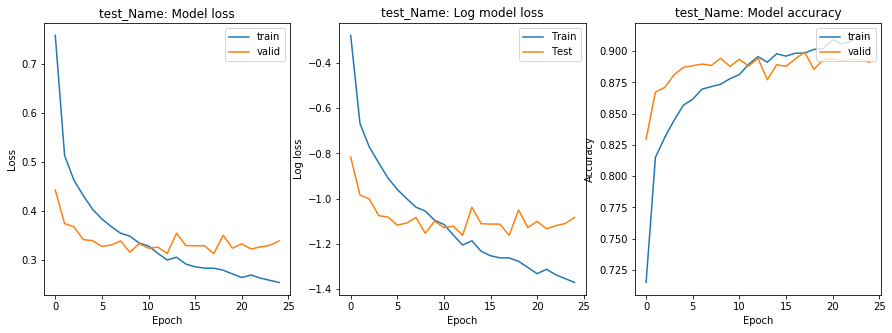

Accuracy: 0.8907293614747529


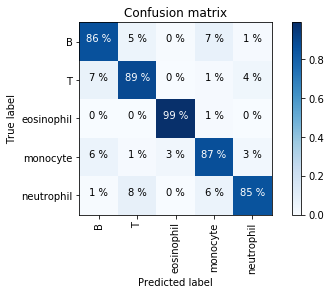

In [98]:
## Plot results
plot_history(history, "test_Name")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)

## Optional

Try using different proportions for training, validation and test. How does this affect your results? Why?